<a href="https://colab.research.google.com/github/CptK1ng/dmc2019/blob/alexander_dev/notebooks/semisupervised_learning_pseudo_labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi Supervised Learning using Pseudo Labeling
by Alexander

inspired by [this blog post](https://towardsdatascience.com/simple-explanation-of-semi-supervised-learning-and-pseudo-labeling-c2218e8c769b).

TODO: Try [tpu sklearn xgboost ml engine](https://cloud.google.com/ml-engine/docs/scikit/getting-started-training)

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import time as time
%matplotlib inline

Download our custom Dataset splits and the unlabeled Test Set:

In [4]:
!wget -nc -q --show-progress https://www.dropbox.com/s/6m8iq9ogpzmu7vx/train_new.csv?dl=1 -O train_new.csv
!wget -nc -q --show-progress https://www.dropbox.com/s/tjpkc45oqn3uv8s/val_new.csv?dl=1 -O val_new.csv
!wget -nc -q --show-progress https://www.dropbox.com/s/hbd6nzgwlnevu4x/test.csv?dl=1 -O test.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


Import Data:

In [2]:
df_train_original = pd.read_csv("../data/train_new.csv", sep="|")
df_val_original = pd.read_csv("../data/val_new.csv", sep="|")
df_test_original = pd.read_csv("../data/test.csv", sep="|")
df_train_original.head(2)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,4,828,66.56,7,4,3,0.007246,0.080386,1.166667,0
1,1,1612,31.34,2,4,3,0.008685,0.019442,0.142857,0


## Feature Engineering

In [3]:
def prepareData(df):
  df = df.copy()
  df['totalLineItems'] = df['scannedLineItemsPerSecond'] * df['totalScanTimeInSeconds'] #nur of scanned products
  return df

df_train = prepareData(df_train_original)
df_val = prepareData(df_val_original)
df_test = prepareData(df_test_original)

df_train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,totalLineItems
0,4,828,66.56,7,4,3,0.007246,0.080386,1.166667,0,6.0
1,1,1612,31.34,2,4,3,0.008685,0.019442,0.142857,0,14.0
2,3,848,52.37,2,4,0,0.022406,0.061757,0.105263,0,19.0
3,1,321,76.03,8,7,2,0.071651,0.236854,0.347826,0,23.0
4,1,660,6.06,3,7,1,0.027273,0.009182,0.166667,0,18.0


## Split X and Y

In [4]:
# Splitting the final dataset into internal training and testing datasets
df_train_X = df_train.drop('fraud', axis=1)
df_train_y = df_train['fraud']
df_val_X = df_val.drop('fraud', axis=1)
df_val_y = df_val['fraud']
df_test_X = df_test.copy()
# df_test_y will be predicted by classificator

X_train, X_val, X_test, y_train, y_val = df_train_X.values, df_val_X.values, df_test_X, df_train_y.values, df_val_y.values
print("Shapes",X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape)

Shapes (1503, 10) (376, 10) (498121, 10) (1503,) (376,)


## Simple Classificator


In [5]:
def score_function(y_true, y_pred):
  dmc = np.sum(metrics.confusion_matrix(y_true, y_pred)*np.array([[0, -25],[ -5, 5]])) #sklearn gives [[tn,fp],[fn,tp]]
  return (0 if all(y_pred == 0) else metrics.fbeta_score(y_true, y_pred, beta=2),
          dmc, 
          dmc/len(y_pred), #comparable relative score, the higher the better.
          metrics.confusion_matrix(y_true, y_pred).tolist())

##  Classify labels for validation set on training set

In [6]:
classifier_adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=500, algorithm='SAMME', random_state=1)

# Fitting the model and printing the accuracy score
classifier_adb.fit(X_train, y_train)
print("AdaBoost", "\t", score_function(y_val, classifier_adb.predict(X_val)) )

AdaBoost 	 (0.8771929824561403, 35, 0.09308510638297872, [[351, 2], [3, 20]])


### Classify labels for test set on training set

In [7]:
#classifier_adb.fit(X_train, y_train)
y_test = classifier_adb.predict(X_test)
print(y_test[1:500])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

### Combine Train and Test Set for new combined Test Set

In [8]:
X_train_new = np.concatenate((X_train, X_test))
y_train_new = np.concatenate((y_train, y_test))
print("Shapes:",X_train_new.shape,y_train_new.shape)

Shapes: (499624, 10) (499624,)


##  Classify labels for validation set on training and testing set
this is hardware intensive and takes a long time!

In [9]:
# Now test inference with semi supervised learned new training dataset
training_set_size = X_test.shape[0]    # maximum is X_test.shape[0], but we can use less for faster training.
                            # TODO: when running on high perfomance CPU, please set to maximum.

start = time.monotonic()
    
classifier_adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=500, algorithm='SAMME', random_state=1)
classifier_adb.fit(X_train_new[0:training_set_size], y_train_new[0:training_set_size])  # training, this is slow and takes long

print("AdaBoost", "\t", score_function(y_val, classifier_adb.predict(X_val)) )            # inference, fast
duration = time.monotonic() - start
print("Duration: ", duration)

AdaBoost 	 (0.8695652173913043, 10, 0.026595744680851064, [[350, 3], [3, 20]])
Duration:  356.31300000000005


### Visualising for different train/test percentages in X_train_new
Plot (normal or relative) DMC Score for increasing number of "training_set_size" to find best number.

this is even more hardware intensive and takes an even long time!

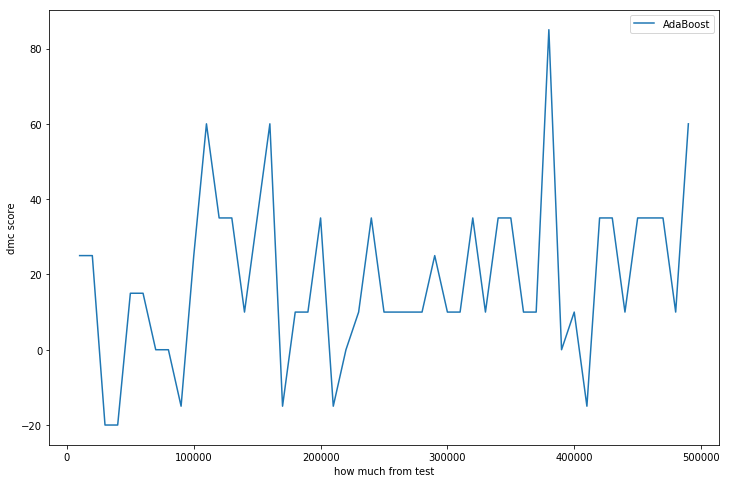

Duration:  8954.61


In [11]:
stepsize = 10000
start_plot = time.monotonic()
dmc_score = []
for i in range(stepsize,training_set_size+1,stepsize):
  classifier_adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=500, algorithm='SAMME', random_state=1)
  classifier_adb.fit(X_train_new[0:i], y_train_new[0:i])  # training, this is slow and takes long
  dmc_score.append(score_function(y_val, classifier_adb.predict(X_val))[1])

plt.figure(figsize=(12, 8))
plt.xlabel('how much from test')
plt.ylabel('dmc score')
plt.plot(range(stepsize,training_set_size+1,stepsize), dmc_score, label="AdaBoost")
plt.legend()
plt.show()
duration_plot = time.monotonic() - start
print("Duration: ", duration_plot)